In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import levene, f_oneway
import warnings
warnings.filterwarnings('ignore')

#my imports
import env
import os
import wrangle as w
import explore as e
import model as m

In [2]:
#Get my data
df = w.acquire_zillow()

In [3]:
df = w.prepare_zillow(df)

In [4]:
df = e.create_features(df)

In [5]:
df = e.get_counties(df)

In [6]:
train, validate, test = w.train_validate_test_split(df)

In [7]:
#Make bins for log error
train['logerror_bins'] = pd.cut(train.log_error, [-5, -.2, -.05, .05, .2, 4])

In [8]:
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura,logerror_bins
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,2832.0,2832.0,6059.0,...,130.530014,0.4,35.481693,0.3,0.625000,0,0,1,0,"(-0.05, 0.05]"
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,2255.0,2255.0,6059.0,...,75.004435,0.3,19.219286,0.2,0.625000,0,0,1,0,"(0.05, 0.2]"
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,1563.0,1563.0,6037.0,...,58.162508,0.2,3.176240,0.1,1.000000,0,1,0,0,"(0.05, 0.2]"
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,1447.0,1447.0,6059.0,...,32.089150,0.1,4.071429,0.1,0.666667,0,0,1,0,"(0.05, 0.2]"
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,1415.0,1415.0,6111.0,...,128.823322,0.4,22.875767,0.3,0.833333,0,0,0,1,"(-0.2, -0.05]"


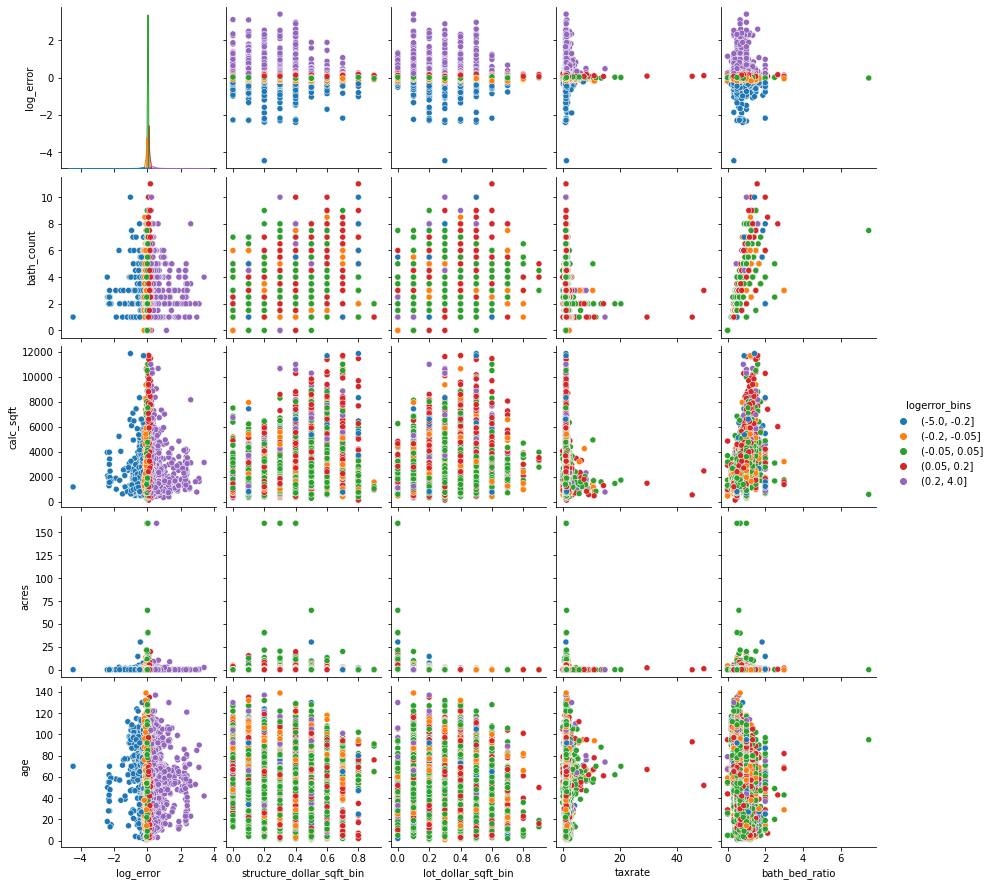

In [17]:
#Pairplot for log error bins
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['log_error', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['log_error', 'bath_count', 'calc_sqft', 'acres', 'age'])

In [ ]:
train.head().T

In [ ]:
#Ensuring no nulls are present
train.isna().sum().sum()

In [9]:
#Scaling variables
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['latitude', 'longitude', 'age'],return_scaler=False):
    '''This function takes in train, validate, test, and outputs scaled data based on
    the chosen method (quantile scaling) using the columns selected as the only columns
    that will be scaled. This function also returns the scaler object as an array if set 
    to true'''
    # make copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
     # select a scaler
    scaler = MinMaxScaler()
     # fit on train
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [7]:
#Scale data through model file
train_scaled, validate_scaled, test_scaled = m.scale_data(train, validate, test, 
                                                        columns_to_scale =
                                                       ['latitude','longitude','age','bath_bed_ratio', 'calc_sqft',
                                                       'taxrate','structure_dollar_per_sqft','tax_value'])

In [8]:
train_scaled.head().T

,38935,31408,30966,5412,45802
parcel_id,1.439237e+07,1.436821e+07,1.130098e+07,1.392600e+07,1.722916e+07
propertylandusetypeid,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
basement_sqft,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bath_count,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
bed_count,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
calc_bath_and_bed,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
decktypeid,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calc_sqft,2.285130e-01,1.793145e-01,1.203104e-01,1.104195e-01,1.076910e-01
finished_sqft12,2.832000e+03,2.255000e+03,1.563000e+03,1.447000e+03,1.415000e+03
fips,6.059000e+03,6.059000e+03,6.037000e+03,6.059000e+03,6.111000e+03


In [11]:
#Building a set for a location cluster
location = train_scaled[['latitude','longitude','age']]

In [13]:
#Fit and predict location
kmeans = KMeans(n_clusters=4)
kmeans.fit(location)
kmeans.predict(location)

array([2, 2, 1, ..., 2, 3, 2], dtype=int32)

In [14]:
train_scaled['location_cluster'] = kmeans.predict(location)

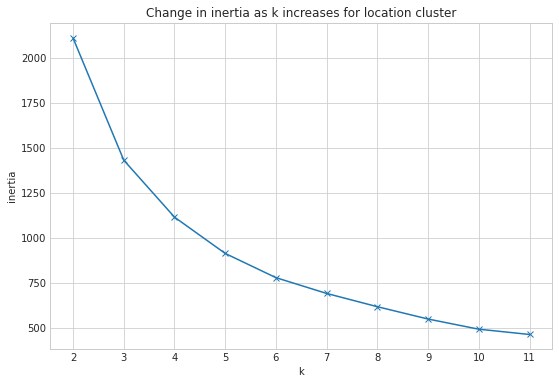

In [29]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(location).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for location cluster')

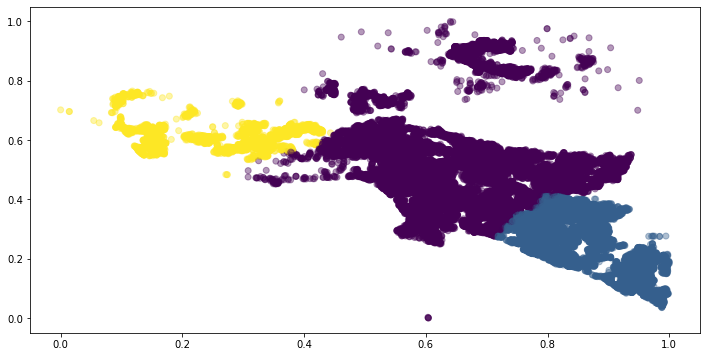

In [38]:
plt.figure(figsize=(12,6))
plt.scatter(y=train_scaled.latitude, x=train_scaled.longitude, c=train_scaled.fips, alpha=.4)

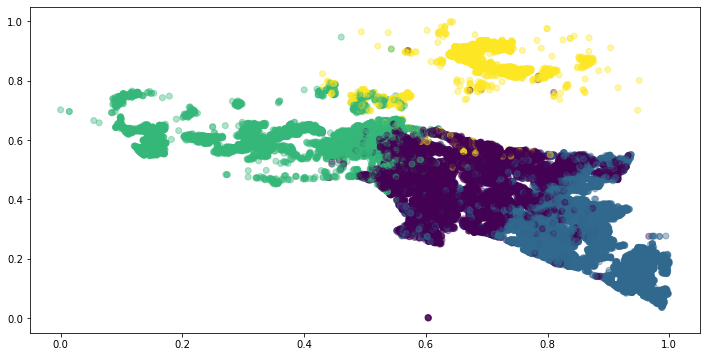

In [39]:
plt.figure(figsize=(12,6))
plt.scatter(y=train_scaled.latitude, x=train_scaled.longitude, c=train_scaled.location_cluster, alpha=.4)
#plt.scatter(y=train_scaled.age, x=train_scaled.longitude, c=train_scaled.location_cluster, alpha=.4)
#plt.scatter(y=train_scaled.age, x=train_scaled.latitude, c=train_scaled.location_cluster, alpha=.4)

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

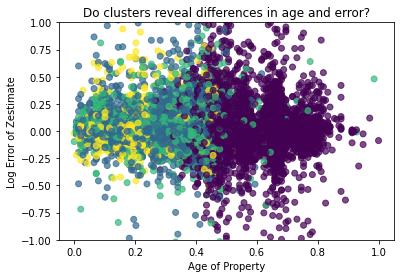

In [40]:
plt.scatter(y=train_scaled.log_error, x=train_scaled.age, c=train_scaled.location_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

In [17]:
#Making a size cluster
size = train_scaled[['bath_bed_ratio','calc_sqft']]
size.head()

,bath_bed_ratio,calc_sqft
38935,0.083333,0.228513
31408,0.083333,0.179314
30966,0.133333,0.120310
5412,0.088889,0.110420
45802,0.111111,0.107691


In [18]:
#Fit and predict
kmeans = KMeans(n_clusters=4)
kmeans.fit(size)
kmeans.predict(size)

array([0, 3, 3, ..., 1, 0, 3], dtype=int32)

In [19]:
#Put it back into train scaled
train_scaled['size_cluster'] = kmeans.predict(size)

In [21]:
train_scaled.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura,logerror_bins,location_cluster,size_cluster
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,0.228513,2832.0,6059.0,...,35.481693,0.3,0.083333,0,0,1,0,"(-0.05, 0.05]",1,3
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,0.179314,2255.0,6059.0,...,19.219286,0.2,0.083333,0,0,1,0,"(0.05, 0.2]",1,0
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,0.120310,1563.0,6037.0,...,3.176240,0.1,0.133333,0,1,0,0,"(0.05, 0.2]",3,0
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,0.110420,1447.0,6059.0,...,4.071429,0.1,0.088889,0,0,1,0,"(0.05, 0.2]",1,2
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,0.107691,1415.0,6111.0,...,22.875767,0.3,0.111111,0,0,0,1,"(-0.2, -0.05]",0,2


In [20]:
#cluster centers
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=size.columns)
centroids

,bath_bed_ratio,calc_sqft
0,0.116828,0.268092
1,0.078669,0.093975
2,0.151386,0.489636
3,0.100228,0.162807


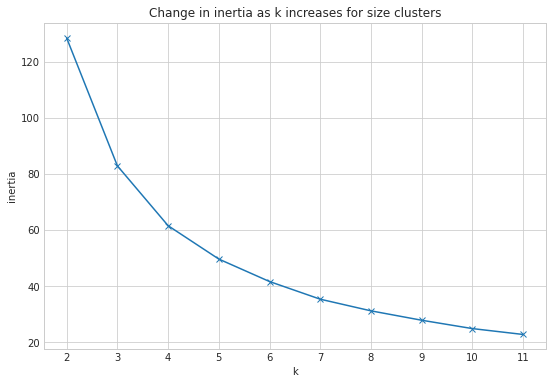

In [39]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(size).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for size clusters')

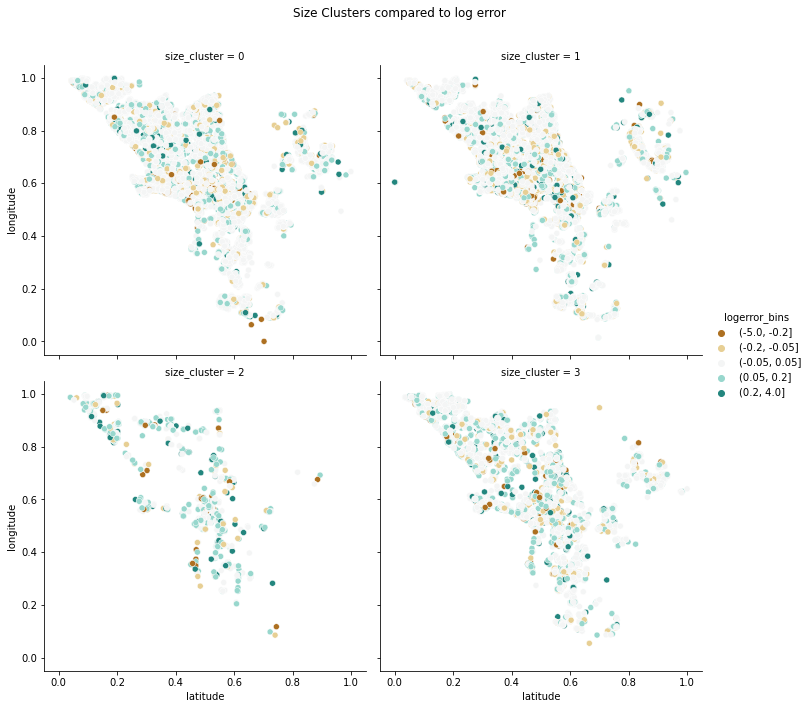

In [45]:
g=sns.relplot(data=train_scaled, 
            x='latitude', 
            y='longitude', 
            hue='logerror_bins', 
            palette='BrBG',
            col='size_cluster', 
            col_wrap=2)
# adjust the top to fit the title
g.fig.subplots_adjust(top=0.9)
# give it a title
g.fig.suptitle('Size Clusters compared to log error')
plt.show()

In [21]:
#Make Value cluster
value = train_scaled[['tax_value','structure_dollar_per_sqft']]

In [22]:
#Fit and predict
kmeans = KMeans(n_clusters=4)
kmeans.fit(value)
kmeans.predict(value)

array([1, 3, 3, ..., 1, 0, 3], dtype=int32)

In [23]:
train_scaled['value_cluster'] = kmeans.predict(value)

In [24]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=value.columns)
centroids

,tax_value,structure_dollar_per_sqft
0,0.062040,0.131540
1,0.022220,0.074362
2,0.215628,0.301633
3,0.009881,0.034780


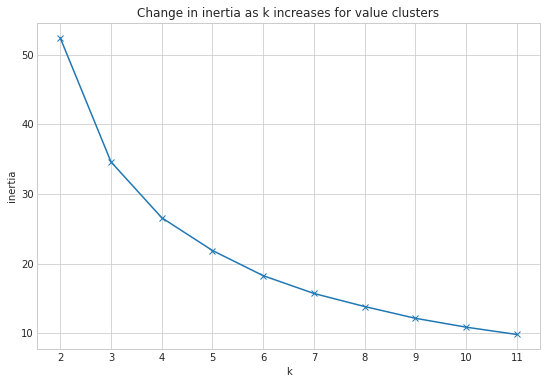

In [64]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(value).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for value clusters')

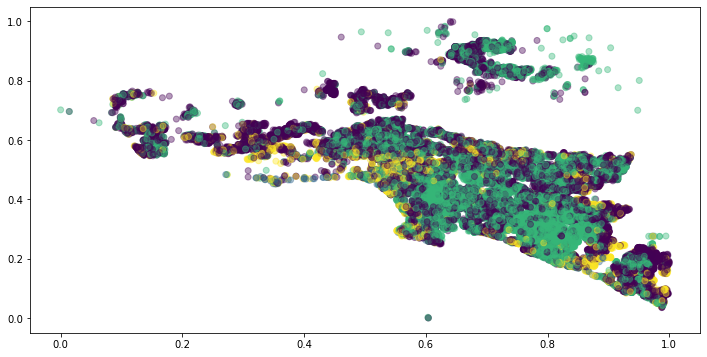

In [65]:
plt.figure(figsize=(12,6))
plt.scatter(y=train_scaled.latitude, x=train_scaled.longitude, c=train_scaled.value_cluster, alpha=.4)
#plt.scatter(y=X_train.age, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)


Text(0.5, 1.0, 'Do clusters reveal differences in value and error?')

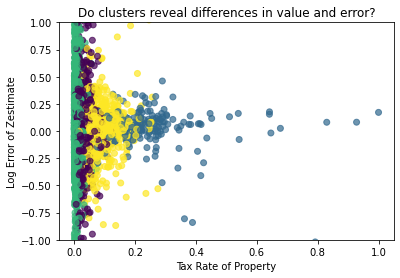

In [66]:
plt.scatter(y=train_scaled.log_error, x=train_scaled.tax_value, c=train_scaled.value_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Tax Rate of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in value and error?")

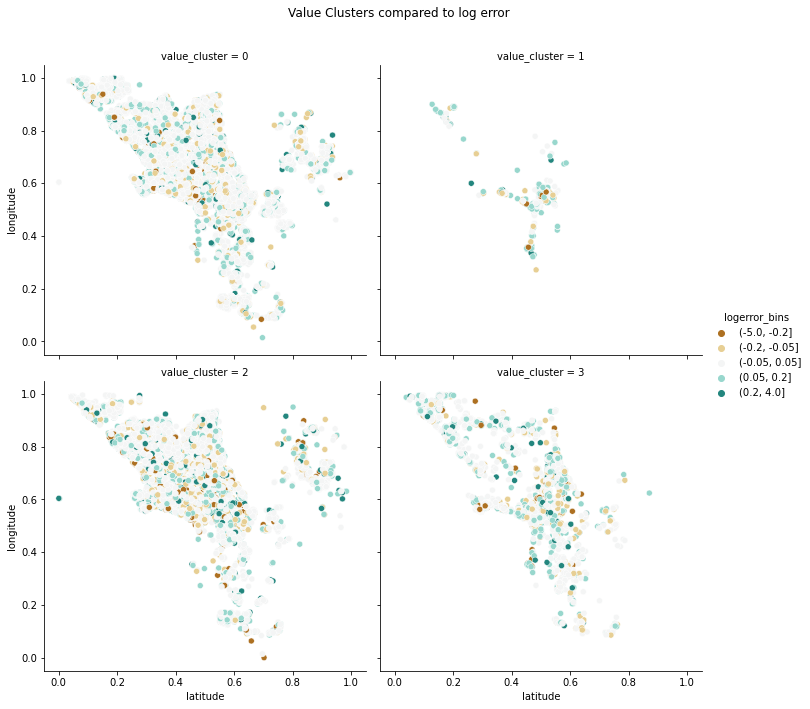

In [67]:
g=sns.relplot(data=train_scaled, 
            x='latitude', 
            y='longitude', 
            hue='logerror_bins', 
            palette='BrBG',
            col='value_cluster', 
            col_wrap=2)
# adjust the top to fit the title
g.fig.subplots_adjust(top=0.9)
# give it a title
g.fig.suptitle('Value Clusters compared to log error')
plt.show()

In [25]:
#Creating dummy variables from location cluster
dummy_1 = pd.get_dummies(train_scaled.location_cluster, columns=['loc_0','loc_1','loc_2','loc_3'])
# Concat these back onto df
train_scaled = pd.concat([train_scaled, dummy_1], axis=1)
#Rename clustered variables
train_scaled.rename(columns = {0:'loc_0',1:'loc_1',2:'loc_2',3:'loc_3'}, inplace = True)

In [29]:
#Creating dummy variables from size cluster
dummy_2 = pd.get_dummies(train_scaled.size_cluster, columns=['size_0', 'size_1', 'size_2', 'size_3'])
# Concat these back onto df
train_scaled = pd.concat([train_scaled, dummy_2], axis=1)
#Rename clustered variables
train_scaled.rename(columns = {0:'size_0',1:'size_1',2:'size_2',3:'size_3'}, inplace = True)

In [31]:
#Creating dummy variables from value cluster
dummy_3 = pd.get_dummies(train_scaled.value_cluster, columns=['value_0','value_1','value_2','value_3'])
# Concat these back onto df
train_scaled = pd.concat([train_scaled, dummy_3], axis=1)
#Rename clustered variables
train_scaled.rename(columns = {0:'value_0',1:'value_1',2:'value_2',3:'value_3'}, inplace = True)

In [32]:
train_scaled.head().T

,38935,31408,30966,5412,45802
parcel_id,14392368,14368210,11300975,13926000,17229160
propertylandusetypeid,261.0,261.0,261.0,261.0,261.0
basement_sqft,0.0,0.0,0.0,0.0,0.0
bath_count,2.5,2.5,3.0,2.0,2.5
bed_count,4.0,4.0,3.0,3.0,3.0
...,...,...,...,...,...
size_3,0,1,1,0,0
value_0,0,0,0,0,0
value_1,1,0,0,0,1
value_2,0,0,0,0,0


In [9]:
def make_clusters(train, train_scaled, validate_scaled, test_scaled):
    
    #Set K value for clusters
    kmeans = KMeans(n_clusters=4, random_state=123)
    
    #Make location cluster
    location = train_scaled[['latitude','longitude','age']]
    #Fit and predict location for k=4
    kmeans.fit(location)
    #Add column back to train scaled for this cluster
    loc_cluster = kmeans.predict(train_scaled[['latitude','longitude','age']])
    train['location_cluster'] = loc_cluster
    train_scaled['location_cluster'] = loc_cluster
    validate_scaled['location_cluster'] = kmeans.predict(validate_scaled[['latitude','longitude','age']])
    test_scaled['location_cluster'] = kmeans.predict(test_scaled[['latitude','longitude','age']])
    
    #Make Size cluster
    size = train_scaled[['bath_bed_ratio','calc_sqft']]
    #Fit and predict
    kmeans.fit(size)
    #Add column back to train scaled for this cluster
    train['size_cluster'] = kmeans.predict(train_scaled[['bath_bed_ratio','calc_sqft']])
    train_scaled['size_cluster'] = kmeans.predict(train_scaled[['bath_bed_ratio','calc_sqft']])
    validate_scaled['size_cluster'] = kmeans.predict(train_scaled[['bath_bed_ratio','calc_sqft']])
    test_scaled['size_cluster'] = kmeans.predict(train_scaled[['bath_bed_ratio','calc_sqft']])
    
    #Make value cluster
    value = train_scaled[['tax_value','structure_dollar_per_sqft']]
    #Fit and predict
    kmeans.fit(value)
    #Add column back to train scaled for this cluster
    train['value_cluster'] = kmeans.predict(train_scaled[['tax_value','structure_dollar_per_sqft']])
    train_scaled['value_cluster'] = kmeans.predict(train_scaled[['tax_value','structure_dollar_per_sqft']])
    validate_scaled['value_cluster'] = kmeans.predict(train_scaled[['tax_value','structure_dollar_per_sqft']])
    test_scaled['value_cluster'] = kmeans.predict(train_scaled[['tax_value','structure_dollar_per_sqft']])
    
    #Creating dummy variables from location cluster
    dummy_1 = pd.get_dummies(train_scaled.location_cluster, columns=['loc_0','loc_1','loc_2','loc_3'])
    # Concat these back onto df
    train = pd.concat([train, dummy_1], axis=1)
    train_scaled = pd.concat([train_scaled, dummy_1], axis=1)
    validate_scaled = pd.concat([validate_scaled, dummy_1], axis=1)
    test_scaled = pd.concat([test_scaled, dummy_1], axis=1)
    #Rename clustered variables
    train.rename(columns = {0:'loc_0',1:'loc_1',2:'loc_2',3:'loc_3'}, inplace = True)
    train_scaled.rename(columns = {0:'loc_0',1:'loc_1',2:'loc_2',3:'loc_3'}, inplace = True)
    validate_scaled.rename(columns = {0:'loc_0',1:'loc_1',2:'loc_2',3:'loc_3'}, inplace = True)
    test_scaled.rename(columns = {0:'loc_0',1:'loc_1',2:'loc_2',3:'loc_3'}, inplace = True)
    
    #Creating dummy variables from size cluster
    dummy_2 = pd.get_dummies(train_scaled.size_cluster, columns=['size_0', 'size_1', 'size_2', 'size_3'])
    # Concat these back onto df
    train = pd.concat([train, dummy_2], axis=1)
    train_scaled = pd.concat([train_scaled, dummy_2], axis=1)
    validate_scaled = pd.concat([train_scaled, dummy_2], axis=1)
    test_scaled = pd.concat([train_scaled, dummy_2], axis=1)
    #Rename clustered variables
    train.rename(columns = {0:'size_0',1:'size_1',2:'size_2',3:'size_3'}, inplace = True)
    train_scaled.rename(columns = {0:'size_0',1:'size_1',2:'size_2',3:'size_3'}, inplace = True)
    validate_scaled.rename(columns = {0:'size_0',1:'size_1',2:'size_2',3:'size_3'}, inplace = True)
    test_scaled.rename(columns = {0:'size_0',1:'size_1',2:'size_2',3:'size_3'}, inplace = True)
    
    #Creating dummy variables from value cluster
    dummy_3 = pd.get_dummies(train_scaled.value_cluster, columns=['value_0','value_1','value_2','value_3'])
    # Concat these back onto df
    train = pd.concat([train, dummy_3], axis=1)
    train_scaled = pd.concat([train_scaled, dummy_3], axis=1)
    validate_scaled = pd.concat([validate_scaled, dummy_3], axis=1)
    test_scaled = pd.concat([test_scaled, dummy_3], axis=1)
    #Rename clustered variables
    train.rename(columns = {0:'value_0',1:'value_1',2:'value_2',3:'value_3'}, inplace = True)
    train_scaled.rename(columns = {0:'value_0',1:'value_1',2:'value_2',3:'value_3'}, inplace = True)
    validate_scaled.rename(columns = {0:'value_0',1:'value_1',2:'value_2',3:'value_3'}, inplace = True)
    test_scaled.rename(columns = {0:'value_0',1:'value_1',2:'value_2',3:'value_3'}, inplace = True)
    
    return train, train_scaled, validate_scaled, test_scaled

In [11]:
train, train_scaled, validate_scaled, test_scaled = make_clusters(train,train_scaled,validate_scaled,test_scaled)

ValueError: Length of values (35455) does not match length of index (7600)

In [15]:
train.head().T

,38935,31408,30966,5412,45802
parcel_id,1.439237e+07,1.436821e+07,1.130098e+07,1.392600e+07,1.722916e+07
propertylandusetypeid,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
basement_sqft,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bath_count,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
bed_count,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
calc_bath_and_bed,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
decktypeid,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calc_sqft,2.832000e+03,2.255000e+03,1.563000e+03,1.447000e+03,1.415000e+03
finished_sqft12,2.832000e+03,2.255000e+03,1.563000e+03,1.447000e+03,1.415000e+03
fips,6.059000e+03,6.059000e+03,6.037000e+03,6.059000e+03,6.111000e+03


# Statistical Testing

### Location

In [10]:
#Making variables for each location cluster for statistical testing
loc_zero = train_scaled[train_scaled['location_cluster']==0]
loc_one =  train_scaled[train_scaled['location_cluster']==1]
loc_two = train_scaled[train_scaled['location_cluster']==2]
loc_three = train_scaled[train_scaled['location_cluster']==3]

In [11]:
print(f'location cluster zero mean log error is: {loc_zero.log_error.mean()}')
print(f'location cluster one mean log error is: {loc_one.log_error.mean()}')
print(f'location cluster two mean log error is: {loc_two.log_error.mean()}')
print(f'location cluster three mean log error is: {loc_three.log_error.mean()}')

location cluster zero mean log error is: 0.013437965158216159
location cluster one mean log error is: 0.027226552455037394
location cluster two mean log error is: 0.018299513365656946
location cluster three mean log error is: 0.016761029196159186


In [12]:
#running stats test for these-first checking variance
stat, p = levene(loc_zero.log_error, loc_one.log_error, loc_two.log_error, loc_three.log_error)
stat, p

(42.956377443613604, 1.0634812185022694e-27)

#### Variances are not equal, make note

In [13]:
#Running anova on these (Kruskal because variances are unequal)
stats.kruskal(loc_zero.log_error, loc_one.log_error, loc_two.log_error, loc_three.log_error)

KruskalResult(statistic=136.62286417281504, pvalue=2.0210094572534475e-29)

### These clusters are statistically different. Lets run a two tailed t-test comparing cluster zero with the population

In [14]:
overall_mean = train_scaled.log_error.mean()
overall_mean

0.01891055300723192

In [15]:
alpha = 0.05

loc_cluster_one = train_scaled[train_scaled.location_cluster == 1].log_error
population_mean = train_scaled.log_error.mean()

t, p = stats.ttest_1samp(loc_cluster_one, overall_mean)

print(t, p, alpha)

4.659703464330919 3.2038886837502667e-06 0.05


### There is a significant difference between the mean log error of location cluster one and the overall dataset mean log error. This cluster has a higher mean log error than the dataset log error

### Size Cluster

In [18]:
#Making variables for each size cluster for statistical testing
size_zero = train_scaled[train_scaled['size_cluster']==0]
size_one =  train_scaled[train_scaled['size_cluster']==1]
size_two = train_scaled[train_scaled['size_cluster']==2]
size_three = train_scaled[train_scaled['size_cluster']==3]

In [19]:
print(f'size cluster zero mean log error is: {size_zero.log_error.mean()}')
print(f'size cluster one mean log error is: {size_one.log_error.mean()}')
print(f'size cluster two mean log error is: {size_two.log_error.mean()}')
print(f'size cluster three mean log error is: {size_three.log_error.mean()}')

size cluster zero mean log error is: 0.015221111380738794
size cluster one mean log error is: 0.030118808812582765
size cluster two mean log error is: 0.01694371748043949
size cluster three mean log error is: 0.054040213673442895


#### Size Cluster three has a very large mean log error

In [20]:
#running stats test for these-first checking variance
stat, p = levene(size_zero.log_error, size_one.log_error, size_two.log_error, size_three.log_error)
stat, p

(35.183017138253945, 1.0751154211058534e-22)

#### Variances are not equal

In [21]:
#Running anova on these (Kruskal because variances are unequal)
stats.kruskal(size_zero.log_error, size_one.log_error, size_two.log_error, size_three.log_error)

KruskalResult(statistic=330.04986653104993, pvalue=3.112589621459891e-71)

#### These clusters are different from each other. Let's look at size cluster two

In [29]:
alpha = 0.05

size_cluster_three = train_scaled[train_scaled.size_cluster == 3].log_error
population_mean = train_scaled.log_error.mean()

t, p = stats.ttest_1samp(size_cluster_three, overall_mean)

print(t, p, alpha)

3.97829204013173 7.658848357180965e-05 0.05


### Size cluster three(3) is significantly different--has a higher mean log error than the dataset

## Value Cluster

In [30]:
overall_mean = train_scaled.log_error.mean()
overall_mean

0.01891055300723192

In [31]:
#Making variables for each value cluster for statistical testing
value_zero = train_scaled[train_scaled['value_cluster']==0]
value_one =  train_scaled[train_scaled['value_cluster']==1]
value_two = train_scaled[train_scaled['value_cluster']==2]
value_three = train_scaled[train_scaled['value_cluster']==3]

In [32]:
print(f'value cluster zero mean log error is: {value_zero.log_error.mean()}')
print(f'value cluster one mean log error is: {value_one.log_error.mean()}')
print(f'value cluster two mean log error is: {value_two.log_error.mean()}')
print(f'value cluster three mean log error is: {value_three.log_error.mean()}')

value cluster zero mean log error is: 0.01493189843710624
value cluster one mean log error is: 0.023389928840280932
value cluster two mean log error is: 0.017025609665894274
value cluster three mean log error is: 0.013551865274868896


#### size cluster one looks to have the most different log error--lets run some tests

In [26]:
#running stats test for these-first checking variance
stat, p = levene(value_zero.log_error, value_one.log_error, value_two.log_error, value_three.log_error)
stat, p

(38.104005727308156, 1.4172346190166228e-24)

#### These clusters have different variances

In [27]:
#Running anova on these (Kruskal because variances are unequal)
stats.kruskal(value_zero.log_error, value_one.log_error, value_two.log_error, value_three.log_error)

KruskalResult(statistic=47.263462430040164, pvalue=3.054821551197247e-10)

#### These clusters have significant differences

In [34]:
alpha = 0.05

value_cluster_one = train_scaled[train_scaled.value_cluster == 1].log_error
population_mean = train_scaled.log_error.mean()

t, p = stats.ttest_1samp(value_cluster_one, overall_mean)

print(t, p, alpha)

3.1599668863238333 0.0015806232207480112 0.05


### Not as strong of a relationship as the previous two, but it is a significant difference between value cluster 1 and log error

### Lets try tax rate significance to log error

In [53]:
train_scaled.taxrate

38935    0.019867
31408    0.020812
30966    0.040025
5412     0.036324
45802    0.024840
           ...   
9007     0.021464
33161    0.024615
42060    0.019884
6307     0.024620
6559     0.027606
Name: taxrate, Length: 35455, dtype: float64

<AxesSubplot:xlabel='taxrate', ylabel='log_error'>

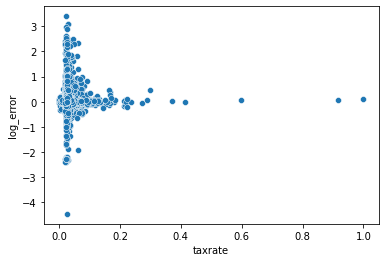

In [54]:
sns.scatterplot(data=train_scaled, x="taxrate", y="log_error")

### Homes with a lower tax rate have lower log error

In [64]:
print(f'Mean tax rate is: {train.taxrate.mean()}')
print(f'Median tax rate is {train.taxrate.median()}')

Mean tax rate is: 1.3332151251825444
Median tax rate is 1.2322926662702594


In [66]:
low_tax_rate = train[(train.taxrate) <(train.taxrate.median())]
high_tax_rate = train[(train.taxrate) >(train.taxrate.median())]

In [67]:
low_tax_rate.log_error.mean()

0.016712587818178446

In [68]:
high_tax_rate.log_error.mean()

0.02110828368989197

#### Running a correlation test between tax rate and log error

In [70]:
corr, p = stats.pearsonr(train.taxrate, train.log_error)
corr, p

(0.013901731343225743, 0.008853485862325386)

#### Running a correlation test between tax value and log error


In [71]:
corr, p = stats.pearsonr(train.tax_value, train.log_error)
corr, p

(-0.002774220417986434, 0.6014236201587851)

#### Running a correlation test between acres and log error

In [73]:
corr, p = stats.pearsonr(train.acres, train.log_error)
corr, p

(0.006477999924254012, 0.22256168340179805)

#### Running a t-test between city of LA and log error

In [77]:
alpha = 0.05

is_LA = train_scaled[train_scaled.cola == 1].log_error
population_mean = train_scaled.log_error.mean()

t, p = stats.ttest_1samp(is_LA, overall_mean)

print(t, p/2, alpha)

-4.132934362077468 1.809332574485712e-05 0.05


#### Very significant relationship here, we will include City of LA in our model. It appears that homes in the city of LA have less log error than homes outside of LA

# Final Visualizations:

## Question three: If we cluster location data with home age, is there a relationship with log error?

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

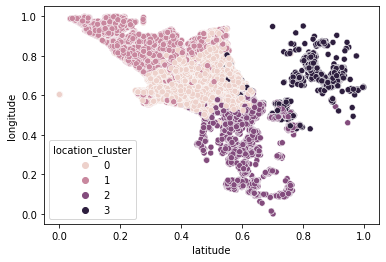

In [37]:
sns.scatterplot(data=train_scaled, x="latitude", y="longitude", hue='location_cluster')

### Without using FIPS codes, we know that location cluster one (1) appears to be mostly Ventura county. This cluster, cluster one, has a significantly different mean log error compared to the training dataset.

## Question four: If we cluster size features, is there a relationship with log error?

<AxesSubplot:xlabel='bath_bed_ratio', ylabel='calc_sqft'>

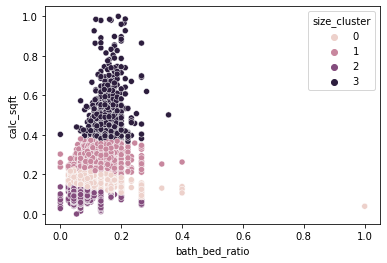

In [41]:
sns.scatterplot(data=train_scaled, x="bath_bed_ratio", y="calc_sqft", hue='size_cluster')

### Size cluster three was formed with larger calculated square feet. This cluster had a higher mean log error. The difference was significant:

In [42]:
#### Insert Statistical Test

## Question Five: If we cluster value features, is there a relationship with log error?

<AxesSubplot:xlabel='tax_value', ylabel='structure_dollar_per_sqft'>

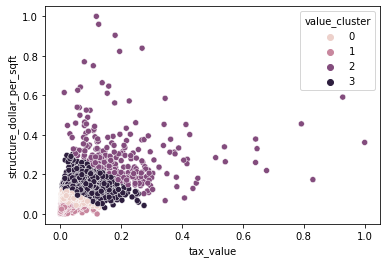

In [43]:
sns.scatterplot(data=train_scaled, x="tax_value", y="structure_dollar_per_sqft", hue='value_cluster')

### Value cluster one, with a lower cost per square footage, and a lower tax value, has a significantly different mean log error than the training dataset mean

# Modeling

In [7]:
#Scale data through model file
train_scaled, validate_scaled, test_scaled = m.scale_data(train, validate, test, 
                                                        columns_to_scale =
                                                       ['latitude','longitude','age','bath_bed_ratio', 'calc_sqft',
                                                       'taxrate','structure_dollar_per_sqft','tax_value'])

In [9]:
def create_clusters(train, train_scaled, validate_scaled, test_scaled):
    '''
    Takes in train and train_scaled and creates clusters for the 
    predefined features. Returns train data with clusters as feature columns
    '''
    kmeans_scale4 = KMeans(n_clusters=4, random_state=123)
    
    #make location cluster with latitude, longitude and age
    kmeans_scale4.fit(train_scaled[['latitude', 'longitude', 'age']])
    train['location_cluster'] = kmeans_scale4.predict(train_scaled[['latitude', 'longitude', 'age']])
    train_scaled['location_cluster'] = kmeans_scale4.predict(train_scaled[['latitude', 'longitude', 'age']])
    validate_scaled['location_cluster'] = kmeans_scale4.predict(validate_scaled[['latitude', 'longitude', 'age']])
    test_scaled['location_cluster'] = kmeans_scale4.predict(test_scaled[['latitude', 'longitude', 'age']])

    #make size cluster with bath bed ratio and calc sqft
    kmeans_scale4.fit(train_scaled[['bath_bed_ratio','calc_sqft']])
    train['size_cluster'] = kmeans_scale4.predict(train_scaled[['bath_bed_ratio','calc_sqft']])
    train_scaled['size_cluster'] = kmeans_scale4.predict(train_scaled[['bath_bed_ratio','calc_sqft']])
    validate_scaled['size_cluster'] = kmeans_scale4.predict(validate_scaled[['bath_bed_ratio','calc_sqft']])
    test_scaled['size_cluster'] = kmeans_scale4.predict(test_scaled[['bath_bed_ratio','calc_sqft']])
    
    #make value cluster with tax value and structure dollar square feet
    kmeans_scale4.fit(train_scaled[['tax_value','structure_dollar_per_sqft']])
    train['value_cluster'] = kmeans_scale4.predict(train_scaled[['tax_value','structure_dollar_per_sqft']])
    train_scaled['value_cluster'] = kmeans_scale4.predict(train_scaled[['tax_value','structure_dollar_per_sqft']])
    validate_scaled['value_cluster'] = kmeans_scale4.predict(validate_scaled[['tax_value','structure_dollar_per_sqft']])
    test_scaled['value_cluster'] = kmeans_scale4.predict(test_scaled[['tax_value','structure_dollar_per_sqft']])
    
    return train, train_scaled, validate_scaled, test_scaled


In [8]:
train, train_scaled, validate_scaled, test_scaled = m.create_clusters(train, train_scaled, validate_scaled, test_scaled)

In [9]:
train.head().T

,38935,31408,30966,5412,45802
parcel_id,1.439237e+07,1.436821e+07,1.130098e+07,1.392600e+07,1.722916e+07
propertylandusetypeid,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
basement_sqft,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bath_count,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
bed_count,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
calc_bath_and_bed,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
decktypeid,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calc_sqft,2.832000e+03,2.255000e+03,1.563000e+03,1.447000e+03,1.415000e+03
finished_sqft12,2.832000e+03,2.255000e+03,1.563000e+03,1.447000e+03,1.415000e+03
fips,6.059000e+03,6.059000e+03,6.037000e+03,6.059000e+03,6.111000e+03


In [12]:
#Encode from mark
def encode_cat_features(train_scaled, validate_scaled, test_scaled, dummy_cols):
    train_scaled = pd.get_dummies(data = train_scaled, columns=dummy_cols)

    validate_scaled = pd.get_dummies(data=validate_scaled, columns=dummy_cols)

    test_scaled = pd.get_dummies(data= test_scaled, columns=dummy_cols)

    return train_scaled, validate_scaled, test_scaled

In [12]:
dummy_cols = ['location_cluster', 'size_cluster', 'value_cluster']

In [13]:
train_scaled, validate_scaled, test_scaled = m.encode_cat_features(train_scaled, validate_scaled, test_scaled, dummy_cols)

In [11]:
train_scaled.head().T

,38935,31408,30966,5412,45802
parcel_id,1.439237e+07,1.436821e+07,1.130098e+07,1.392600e+07,1.722916e+07
propertylandusetypeid,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
basement_sqft,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bath_count,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
bed_count,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
calc_bath_and_bed,2.500000e+00,2.500000e+00,3.000000e+00,2.000000e+00,2.500000e+00
decktypeid,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calc_sqft,2.285130e-01,1.793145e-01,1.203104e-01,1.104195e-01,1.076910e-01
finished_sqft12,2.832000e+03,2.255000e+03,1.563000e+03,1.447000e+03,1.415000e+03
fips,6.059000e+03,6.059000e+03,6.037000e+03,6.059000e+03,6.111000e+03
